In [1]:
%load_ext cudf.pandas
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools import *
from scipy import stats
from omegaconf import OmegaConf
from pprint import PrettyPrinter
from models._main import get_model
from scipy.stats import gaussian_kde
from models._utils import print_parameters

sns.set_style("whitegrid")
pp = PrettyPrinter(indent=4, width=100, compact=True)

CUDA device found.


# Color and Marker code

*Returns the legend code that is used across all plots.*

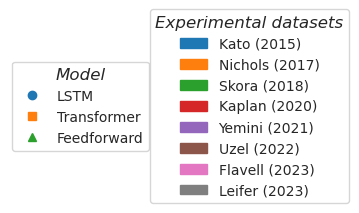

{   'color_legend': [   <matplotlib.patches.Patch object at 0x14fac082c790>,
    'dataset_labels': [   'Kato (2015)', 'Nichols (2017)', 'Skora (2018)', 'Kaplan (2020)',
                          'Yemini (2021)', 'Uzel (2022)', 'Flavell (2023)', 'Leifer (2023)'],
    'ds_color_code': {   'Flavell': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
                         'Kaplan': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                         'Kato': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                         'Leifer': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                         'Nichols': (1.0, 0.4980392156862745, 0.054901960784313725),
                         'Skora': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                         'Uzel': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
                         'Yemini': (0.5803921568627451, 0.4039215686

In [2]:
leg_code = legend_code()
pp.pprint(leg_code)

# Helper code

In [3]:
def get_results_df(results_root_dir):
    """
    Traverses the experiment directories, reads train_metrics.csv and
    validation_loss_per_dataset.csv files, and combines the data into a comprehensive DataFrame.

    Parameters:
    - results_root_dir: The root directory where the experiment directories are located.

    Returns:
    - A DataFrame containing all the combined results from the experiments.
    """

    results = []

    # Iterate over each seed directory
    for seed_dir in next(os.walk(results_root_dir))[1]:
        seed_path = os.path.join(results_root_dir, seed_dir)

        # Iterate over each timestamp directory within the seed directory
        for timestamp_dir in next(os.walk(seed_path))[1]:
            timestamp_path = os.path.join(seed_path, timestamp_dir)

            # Iterate over each experiment directory within the timestamp directory
            for exp_dir in next(os.walk(timestamp_path))[1]:
                exp_path = os.path.join(timestamp_path, exp_dir)

                # Define the paths to the required csv files
                train_metrics_path = os.path.join(
                    exp_path, "train", "train_metrics.csv"
                )
                validation_loss_path = os.path.join(
                    exp_path, "analysis", "validation_loss_per_dataset.csv"
                )

                # Check if the required csv files exist
                if os.path.exists(train_metrics_path) and os.path.exists(
                    validation_loss_path
                ):
                    # Read the csv files
                    train_metrics_df = pd.read_csv(train_metrics_path)
                    validation_loss_df = pd.read_csv(validation_loss_path)

                    # Extract parameters using the provided experiment_parameter function
                    experiment_seed = experiment_parameter(exp_path, "experiment_seed")[
                        0
                    ]
                    num_worms = experiment_parameter(exp_path, "num_worms")[0]
                    num_time_steps = experiment_parameter(exp_path, "num_time_steps")[0]
                    num_named_neurons = experiment_parameter(
                        exp_path, "num_named_neurons"
                    )[0]
                    time_steps_per_neuron = experiment_parameter(
                        exp_path, "time_steps_per_neuron"
                    )[0]
                    num_parameters = experiment_parameter(exp_path, "num_parameters")[0]
                    model_type = experiment_parameter(exp_path, "model")[0]

                    # Calculate the min_val_loss and val_baseline
                    min_val_loss = train_metrics_df["val_loss"].min()
                    val_baseline = train_metrics_df["val_baseline"].median()

                    # Append data to the results list
                    for _, row in validation_loss_df.iterrows():
                        results.append(
                            {
                                "experiment_ID": exp_dir,
                                "experiment_seed": experiment_seed,
                                "num_worms": num_worms,
                                "num_time_steps": num_time_steps,
                                "num_named_neurons": num_named_neurons,
                                "time_steps_per_neuron": time_steps_per_neuron,
                                "num_parameters": num_parameters,
                                "model_type": model_type,
                                "min_val_loss": min_val_loss,
                                "val_baseline": val_baseline,
                                "validation_dataset": row["dataset"],
                                "validation_loss": row["validation_loss"],
                                "validation_baseline": row["validation_baseline"],
                            }
                        )

    return pd.DataFrame(results)


# Usage example:
results_root_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/"
combined_results_df = get_results_df(results_root_directory)
combined_results_df  # .head()

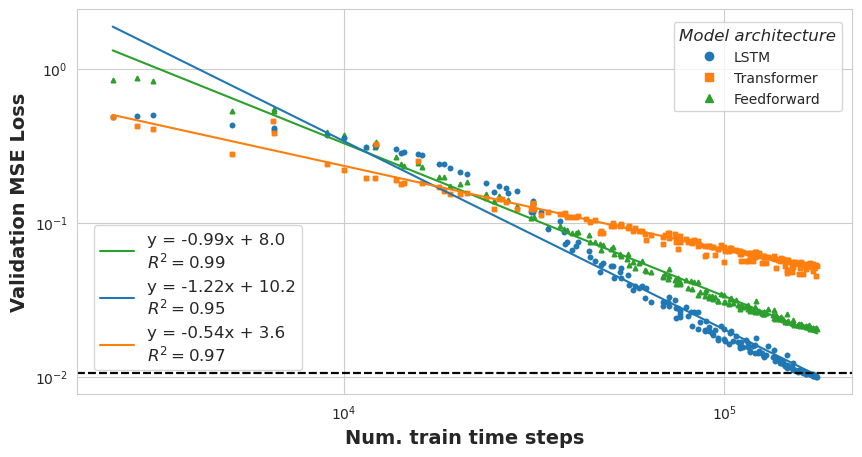

In [7]:
def data_scaling_plot(combined_results_df, legend_code):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_xscale("log")
    ax.set_yscale("log")

    for model_type, group in combined_results_df.groupby("model_type"):
        # Obtain values for plotting
        nts = group["num_time_steps"]
        val_loss = group["min_val_loss"]
        baseline_loss = group["val_baseline"].iloc[
            0
        ]  # Assuming baseline is constant per model type

        # Plot settings from legend_code
        model_label = legend_code["model_labels"][model_type]
        marker = legend_code["model_marker_code"][model_label]
        color = legend_code["model_color_code"][model_label]

        # Scatter plot
        ax.scatter(
            nts,
            val_loss,
            marker=marker,
            color=color,
            s=9,
            label=None,
            alpha=0.3,
        )

        # Baseline plot
        ax.axhline(
            baseline_loss,
            label="Baseline"
            if model_type == list(legend_code["model_labels"].values())[0]
            else "_nolegend_",
            color="black",
            alpha=0.7,
            linestyle="--",
        )

        # Regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            np.log(nts), np.log(val_loss)
        )
        fit_label = f"y = {slope:.2f}x + {intercept:.1f}\n" f"$R^2={r_value**2:.2f}$"
        x_fit = np.linspace(nts.min(), nts.max(), 10000)
        y_fit = np.exp(intercept + slope * np.log(x_fit))

        ax.plot(x_fit, y_fit, color=color, label=fit_label)

    # Handles and labels for first legend
    handles, labels = ax.get_legend_handles_labels()

    # Create the second legend
    legend2 = ax.legend(
        handles=legend_code["marker_legend"],
        loc="center right",
        bbox_to_anchor=(0.995, 0.85),
        title="Model architecture",
    )
    ax.get_legend().get_title().set_fontstyle("italic")
    ax.get_legend().get_title().set_fontsize("large")
    ax.add_artist(legend2)

    # Display both legends
    ax.legend(
        handles, labels, loc="center left", bbox_to_anchor=(0.01, 0.25), fontsize=12
    )

    ax.set_xlabel("Num. train time steps", fontsize=14, fontweight="bold")
    ax.set_ylabel("Validation MSE Loss", fontsize=14, fontweight="bold")

    plt.show()


# Usage example:
results_root_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_time_steps/experimental"
combined_results_df = get_results_df(results_root_directory)
combined_results_df.head()

# To use the function, pass the DataFrame and legend code as arguments
data_scaling_plot(combined_results_df, leg_code)

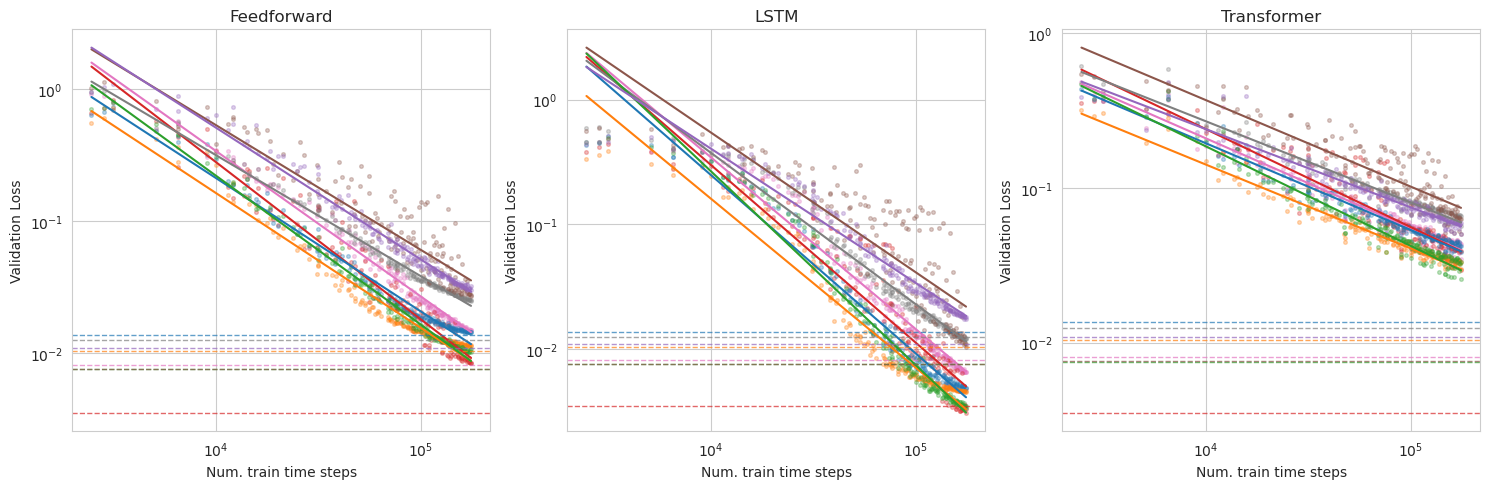

In [9]:
def scaling_slopes_plot(combined_results_df, legend_code):
    fig, axs = plt.subplots(
        1, len(combined_results_df["model_type"].unique()), figsize=(15, 5)
    )

    if len(combined_results_df["model_type"].unique()) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    for idx, (model_type, group) in enumerate(
        combined_results_df.groupby("model_type")
    ):
        model_label = legend_code["model_labels"][model_type]

        ax = axs[idx]
        ax.set_xscale("log")
        ax.set_yscale("log")

        for dataset_label, dataset_group in group.groupby("validation_dataset"):
            color = legend_code["original_ds_color_code"][dataset_label]

            # Scatter plot for individual dataset
            ax.scatter(
                dataset_group["num_time_steps"],
                dataset_group["validation_loss"],
                s=7,
                color=color,
                label=dataset_label,
                alpha=0.3,
            )

            # Baseline horizontal line
            baseline_loss = dataset_group["validation_baseline"].iloc[0]
            ax.axhline(
                y=baseline_loss,
                color=color,
                linestyle="--",
                linewidth=1,
                alpha=0.7,
                label=f"{dataset_label} baseline",
            )

            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                np.log(dataset_group["num_time_steps"]),
                np.log(dataset_group["validation_loss"]),
            )

            # Plot regression line
            x_reg = np.linspace(
                dataset_group["num_time_steps"].min(),
                dataset_group["num_time_steps"].max(),
                100,
            )
            y_reg = np.exp(intercept + slope * np.log(x_reg))
            ax.plot(x_reg, y_reg, color=color)

        ax.set_title(model_label)
        ax.set_xlabel("Num. train time steps")
        ax.set_ylabel("Validation Loss")

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


# Usage example:
results_root_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_time_steps/experimental"
combined_results_df = get_results_df(results_root_directory)
combined_results_df.head()

# Example usage:
scaling_slopes_plot(combined_results_df, leg_code)

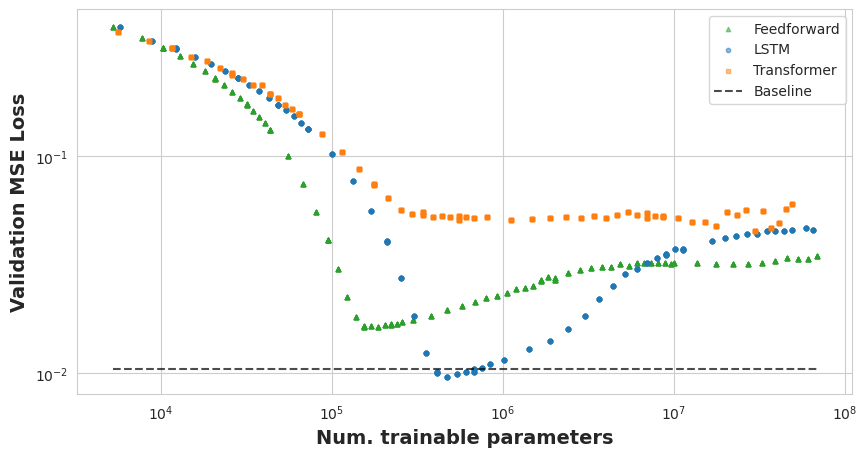

In [8]:
def hidden_scaling_plot(combined_results_df, legend_code):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Group the DataFrame by 'model_type' and plot
    for model_type, group in combined_results_df.groupby("model_type"):
        # Plot settings from legend_code
        model_label = legend_code["model_labels"][model_type]
        marker = legend_code["model_marker_code"][model_label]
        color = legend_code["model_color_code"][model_label]

        # Scatter plot of validation loss vs. number of parameters
        ax.scatter(
            group["num_parameters"],
            group["min_val_loss"],
            marker=marker,
            s=10,
            color=color,
            label=model_label,
            alpha=0.5,  # Adjust alpha to your preference
        )

    baseline = combined_results_df["val_baseline"].unique()
    ax.plot(
        [
            combined_results_df["num_parameters"].min(),
            combined_results_df["num_parameters"].max(),
        ],
        [baseline.mean(), baseline.mean()],
        label="Baseline",
        color="black",
        alpha=0.7,
        linestyle="--",
    )

    # Create legends
    ax.legend(loc="best")
    ax.set_xlabel("Num. trainable parameters", fontsize=14, fontweight="bold")
    ax.set_ylabel("Validation MSE Loss", fontsize=14, fontweight="bold")
    plt.show()


# Usage example:
results_root_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/experimental"
combined_results_df = get_results_df(results_root_directory)
combined_results_df.head()

# Example usage:
hidden_scaling_plot(combined_results_df, leg_code)

# Model Parameters

In [3]:
model_config = OmegaConf.load("../../configs/submodule/model.yaml")
model_config.model.use_this_pretrained_model = None
model = get_model(model_config.model)
print_parameters(model, verbose=True)

+-----------------------------+------------+-----------+
|            Module           | Parameters | Trainable |
+-----------------------------+------------+-----------+
|    input_hidden.0.weight    |   154624   |    True   |
|     input_hidden.0.bias     |    512     |    True   |
|    input_hidden.2.weight    |    512     |    True   |
|     input_hidden.2.bias     |    512     |    True   |
| hidden_hidden.ffwd.0.weight |   262144   |    True   |
|  hidden_hidden.ffwd.0.bias  |    512     |    True   |
|        linear.weight        |   154624   |    True   |
|         linear.bias         |    302     |    True   |
+-----------------------------+------------+-----------+
Total Parameters: 573742
Total Trainable Parameters: 573742


(573742, 573742)

# Dataset information

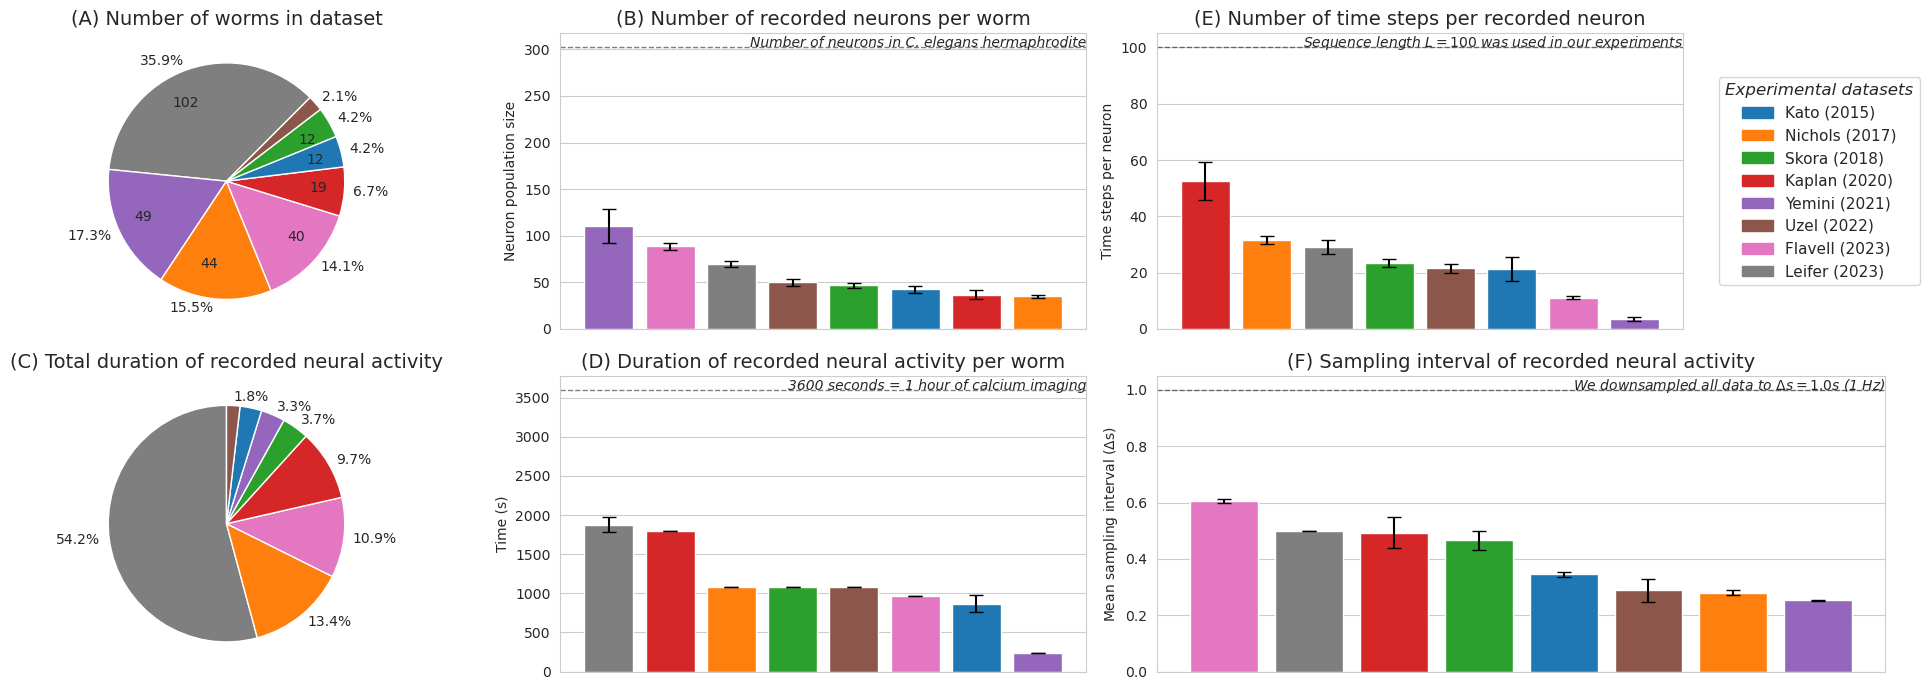

In [4]:
fig1_path_dict = {
    "train_dataset_info": "/om2/user/qsimeon/worm-graph/data/train_AllExperimental/train_dataset_info.csv",  # Path to train dataset info => extract number of train time steps
    "val_dataset_info": "/om2/user/qsimeon/worm-graph/data/validation_AllExperimental/val_dataset_info.csv",  # Path to val. dataset info => extract number of val. time steps
    "combined_dataset_info": "/om2/user/qsimeon/worm-graph/data/combined_AllExperimental/combined_dataset_info.csv",  # Path to combined dataset info => extract total number of worms and time step interval
}

# NOTE: Error bars on bar plots show +/- 2 SEM
dataset_info = dataset_information(path_dict=fig1_path_dict, legend_code=leg_code)

# Data scaling

In [5]:
# Specify path to where results are stored for this experiment
results_dir = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_time_steps/experimental"

nts_experiments = {
    "Feedforward": [  # Feedforward trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_27_03"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_42_34"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_57_40"),
    ],
    "LSTM": [  # LSTM trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_51_11"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_45_46"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_58_30"),
    ],
    "Transformer": [  # Transformer trials
        os.path.join(results_dir, "seed_0/2023_11_27_23_53_07"),
        os.path.join(results_dir, "seed_1/2023_11_27_12_47_28"),
        os.path.join(results_dir, "seed_2/2023_11_29_14_58_54"),
    ],
}

# Retrieve the relevant results
data_scaling_results = data_scaling_df(nts_experiments)

# Building the DataFrame took ~45s on OpenMind cluster
data_scaling_results

,experiment_ID,model_type,hidden_size,num_parameters,num_worms,num_time_steps,time_steps_per_neuron,num_named_neurons,min_val_loss,val_baseline
0,exp0,FeatureFFNN,512,573742,5,3148,11.000000,193,0.826815,0.010516
1,exp1,FeatureFFNN,512,573742,10,5071,9.316316,219,0.532222,0.010516
2,exp10,FeatureFFNN,512,573742,55,31666,9.862745,243,0.108318,0.010516
3,exp11,FeatureFFNN,512,573742,60,40776,11.253472,243,0.085431,0.010516
4,exp12,FeatureFFNN,512,573742,65,36987,9.862745,243,0.095273,0.010516
...,...,...,...,...,...,...,...,...,...,...
493,exp55,NeuralTransformer,262,573296,280,174569,11.114583,247,0.044973,0.010516
494,exp6,NeuralTransformer,262,573296,35,20149,10.568627,242,0.152709,0.010516
495,exp7,NeuralTransformer,262,573296,40,19011,7.110525,243,0.153420,0.010516
496,exp8,NeuralTransformer,262,573296,45,24774,7.851485,243,0.122836,0.010516


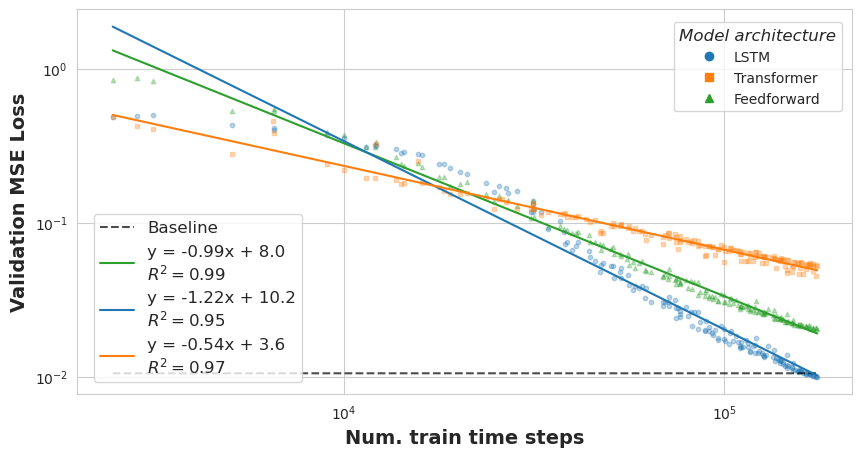

In [7]:
data_scaling_plot(data_scaling_results, legend_code=leg_code)

## Data Scaling for Individual Datasets

In [7]:
# Retrieve the relevant results
scaling_slope_results = scaling_slopes_df(nts_experiments)

# Building the DataFrame took ~2m35s on OpenMind cluster
scaling_slope_results

,experiment_ID,model_type,validation_dataset,individual_validation_loss,individual_baseline_loss,num_parameters,num_worms,num_time_steps,min_val_loss,val_baseline
0,exp0,FeatureFFNN,Kato2015,0.723594,0.013651,573742,5,3148,0.826815,0.010516
1,exp0,FeatureFFNN,Nichols2017,0.713596,0.010331,573742,5,3148,0.826815,0.010516
2,exp0,FeatureFFNN,Skora2018,0.790223,0.007510,573742,5,3148,0.826815,0.010516
3,exp0,FeatureFFNN,Kaplan2020,0.821712,0.003506,573742,5,3148,0.826815,0.010516
4,exp0,FeatureFFNN,Yemini2021,1.088353,0.010871,573742,5,3148,0.826815,0.010516
...,...,...,...,...,...,...,...,...,...,...
3979,exp9,NeuralTransformer,Kaplan2020,0.068865,0.003506,573296,50,28532,0.122155,0.010516
3980,exp9,NeuralTransformer,Yemini2021,0.144439,0.010871,573296,50,28532,0.122155,0.010516
3981,exp9,NeuralTransformer,Uzel2022,0.144689,0.007564,573296,50,28532,0.122155,0.010516
3982,exp9,NeuralTransformer,Flavell2023,0.114526,0.008092,573296,50,28532,0.122155,0.010516


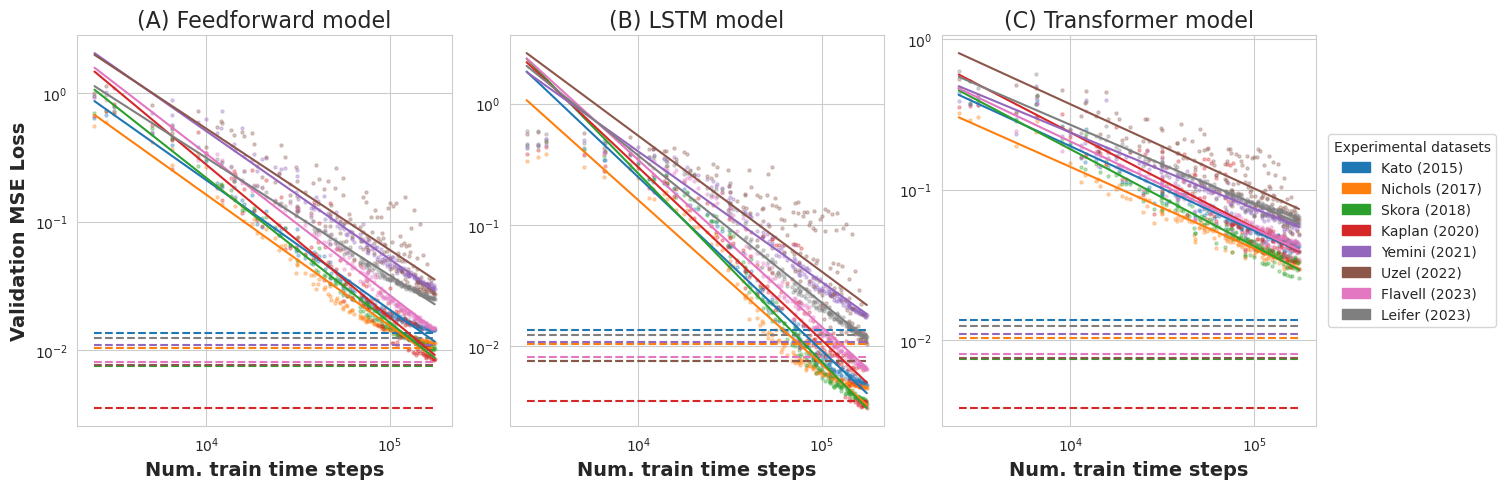

In [8]:
scaling_slopes_plot(scaling_slope_results, legend_code=leg_code)

# Number of Parameters Scaling

In [9]:
# Instead of plotting against the hidden size, plot against the number of parameters.
# The hidden size is simply the "knob" that we turn (i.e. the variable) as way to vary the number of parameters.

# Specify path to where results are stored for this experiment
results_dir = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/experimental"

size_experiments = {
    "Feedforward": [  # Feedforward trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_47_42"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_41_41"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_32_53"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_01_12"),
        os.path.join(results_dir, "seed_4/2023_11_30_15_20_16"),
    ],
    "LSTM": [  # LSTM trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_49_29"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_42_25"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_33_22"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_13_04"),
        # os.path.join(results_dir, "seed_4/2023_11_30_19_15_45"),
    ],
    "Transformer": [  # Transformer trials
        os.path.join(results_dir, "seed_0/2023_11_28_12_51_19"),
        os.path.join(results_dir, "seed_1/2023_11_28_17_45_03"),
        os.path.join(results_dir, "seed_2/2023_11_28_20_39_53"),
        os.path.join(results_dir, "seed_3/2023_11_29_12_15_42"),
    ],
}

# Retrieve the relevant results
size_scaling_results = data_scaling_df(size_experiments)

# Building the DataFrame took ~25s on OpenMind cluster
size_scaling_results

,experiment_ID,model_type,hidden_size,num_parameters,num_worms,num_time_steps,time_steps_per_neuron,num_named_neurons,min_val_loss,val_baseline
0,exp0,FeatureFFNN,1024,1671470,284,176402,11.0,247,0.026755,0.010516
1,exp1,FeatureFFNN,1152,2027822,284,176402,11.0,247,0.027618,0.010516
2,exp10,FeatureFFNN,2304,6709550,284,176402,11.0,247,0.032370,0.010516
3,exp11,FeatureFFNN,2432,7393582,284,176402,11.0,247,0.032139,0.010516
4,exp12,FeatureFFNN,2560,8110382,284,176402,11.0,247,0.032187,0.010516
...,...,...,...,...,...,...,...,...,...,...
199,exp5,NeuralTransformer,28,22226,284,176402,11.0,247,0.254144,0.010516
200,exp6,NeuralTransformer,32,26126,284,176402,11.0,247,0.237500,0.010516
201,exp7,NeuralTransformer,36,30218,284,176402,11.0,247,0.228002,0.010516
202,exp8,NeuralTransformer,40,34502,284,176402,11.0,247,0.212939,0.010516


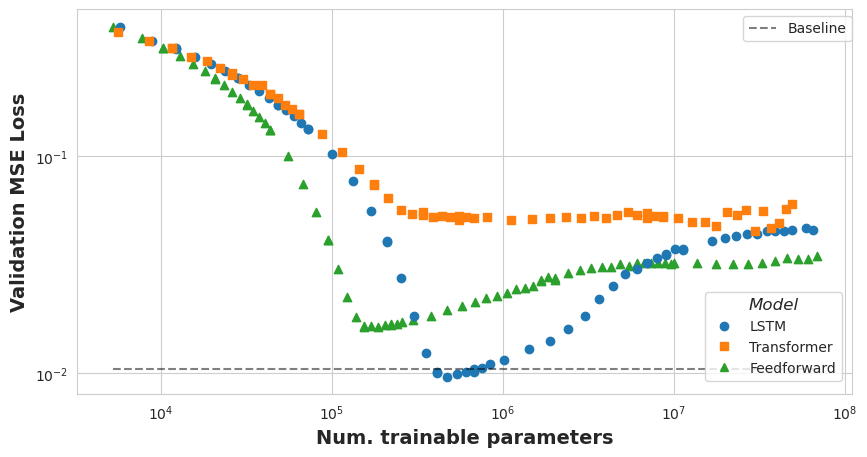

In [10]:
hidden_scaling_plot(size_results, legend_code=leg_code)

# STOP HERE! 
## Got everything above this point to work.

In [ ]:
exit(0)

# Cross-dataset Generalization

*This function automatically loads the results from the indicated experiments and displays a heatmap plot showing the validation loss on individual experimental datasets after a model has been trained (from scratch) using a single experimental dataset.*

*You need to specify the model names respective to each experiment and also the legend color code.*

In [ ]:
experiment_log_folders = [
    os.path.join("results", "CDS_LINEAR"),  # Linear trial 1
    os.path.join("results", "CDS_LSTM"),  # LSTM trial 1
    os.path.join("results", "CDS_TRANSFORMER"),  # Transformer trial 1
]

model_names = ["Feedforward", "LSTM", "Transformer"]

cross_dataset(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
)

# Predictions

*Load and plot the predictions for the same neuron across different datasets. You need to determine which neurons are common to all datasets (I did it manually).*

In [ ]:
experiment_log_folders = [
    os.path.join("results", "NTS_LSTM_2"),  # LSTM trial 1
    os.path.join("results", "NTS_TRANSFORMER_2"),  # Transformer trial 1
    os.path.join("results", "NTS_LINEAR_2"),  # Linear trial 1
]

model_names = ["LSTM", "Transformer", "Linear"]

ds_type = "val"  # we are plotting the predictions using the validation dataset (data never seen during training, second split)
exp = "exp5"  # model trained with maximum amount of data (best model to use for predictions)
neuron_to_plot = "AVER"  # neuron we want to plot

teacher_forcing(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
    ds_type=ds_type,
    exp=exp,
    neuron_to_plot=neuron_to_plot,
)

In [ ]:
autoregressive(
    experiment_log_folders=experiment_log_folders,
    model_names=model_names,
    legend_code=leg_code,
    ds_type=ds_type,
    exp=exp,
    neuron_to_plot=neuron_to_plot,
)

# (Sup. fig) Prediction gap

*Loads the relevant results and plots the refinement of the prediction plot as the amount of training data for the LSTM model increases.*

In [ ]:
pred_gap_df = prediction_gap(
    exp_nts_log_dir=os.path.join("results", "NTS_LSTM_1"),
    legend_code=leg_code,
    neuronID="AVER",
    wormID="worm1",
    datasetID="Flavell2023",
)